# Transfer learning - KerasApplications

Keras API allows us to reuse a model architecture already pre-trained in other DataSet. When applying transfer learning into our DataSet for classifying Alzheimer, we take features learned on one problem, and leveraging them on a new, similar problem. Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model, e.g. only the convolutional and pooling layers
2. Freeze them, to avoid destroying any of the information they contain during future training rounds
3. Add some new, trainable layers on top of the frozen layers, e.g: dense layers
4. Train the new layers set on the new dataset

In this notebook we will use the Keras Applications -> https://keras.io/api/applications/ 

Hint (!) Model's indexes used in this notebboks refer to following:
- model-1: model architecture with 2 classification layers, 50 neurons each, conv and pooling layers are not trainable
- model-2: model architecture with 1 classification layer, 512 neurons, conv and pooling layers are not trainable
- model-3: model architecture with 1 classification layer, 512 neurons, conv and pooling layers are trainable

In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
import keras.backend as K
from tensorflow.keras.utils  import to_categorical, image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass

keras.backend.clear_session()

#new
import keras_tuner
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet201, InceptionV3
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras_unet.models import vanilla_unet

from keras.backend import manual_variable_initialization


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## Loading images data set

### Load Train Set

In [2]:
# load dataset from drive
PATH = "/Users/josealbertodiazsalas/Downloads/Alzheimer_s Dataset/train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )



Found 4136 files belonging to 4 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-14 13:50:27.123257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-14 13:50:27.123379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

### Load Validation Set
<i>-for training-<i>

In [4]:
# load dataset from drive
PATH = "/Users/josealbertodiazsalas/Downloads/Alzheimer_s Dataset/validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 1037 files belonging to 4 classes.


### Load Validation Set
<i>-deconstruct for evaluation-<i>

In [5]:
# NOT SHUFFLED load dataset from drive
PATH = "/Users/josealbertodiazsalas/Downloads/Alzheimer_s Dataset/validation"
IMAGE_SIZE = (208, 176)
val_no_shuffle = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_no_shuffle = val_no_shuffle.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 1037 files belonging to 4 classes.


In [6]:
# seperate images and labels for evaluation.

X_val = []
y_val = []

for img, label in val_no_shuffle.unbatch():
    X_val.append(img.numpy())
    y_val.append(label.numpy())
    
X_val = np.array(X_val)
y_val = np.array(y_val)

X_val, y_val = shuffle(X_val, y_val, random_state=10)

2022-06-14 13:50:27.372696: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Build CNN Architecture and Model Fitting

Following aspects to be considered:
- ImageNet weight will be used for all cases
- All models will be trained in 30 epochs

In [7]:
# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=train_ds.cardinality().numpy()*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

In [8]:
def base_model(MODEL, input_shape=(208, 176, 3), classes=4, freeze_layers=True):
    '''
    Creates base model from keras applications pre-trained architectures. Model includes weights from ImageNet data set

    MODEL: pre-trained keras model tp be set (VGG16, ResNet50, inceptionV3, Densenet201])
    input_shape: image size as it is after loading data sets, 3 channels are needed <- TBD, maybe it should be related to a global variable
    classes: end classes number, default value set to 4
    freeze_layers: it defines whether the layers from pre-trained model are trainable, set not to train only the classification (dense) layers
    '''
    
    # include_top: set to False, since I'm going to use my input and output dimensions
    # weights: taking the weight of pre-trained model, otherwise will be initialized randomly
    # input_shape: possible to set if include_top = False
    # classes: otherwise 1000 classes coming from ImageNet Dataset
    
    # Defining instances of each model
    if MODEL== 'VGG16':
        model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(208, 176, 3), classes=4, classifier_activation="softmax")
    elif MODEL== 'ResNet50':
        model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(208, 176, 3), classes=4, classifier_activation="softmax")
    elif MODEL=='InceptionV3':
        model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(208, 176, 3), classes=4, classifier_activation="softmax")
    elif MODEL=='DenseNet201':
        model = tf.keras.applications.DenseNet201(include_top=False, weights="imagenet", input_shape=(208, 176, 3), classes=4, classifier_activation='softmax')

    # Print only Conv and Pooling layer from model architecture
    #print('PRE-TRAINED MODEL ARCHITECTURE')
    #base_model.summary()
    
    # Freezing the weights of pre-trained layers for making not trainable
    if freeze_layers is True:
        #model.layers.trainable = False
        for layer in model.layers:
            layer.trainable = False
    else:
        pass

    return model

In [9]:
def cnn_model(n_dense_layers, dense_layer_size, n_classes=4):
    '''
    Creates final model containing last classification layers followed by dense layers preceded by the pre-trained model
    
    n_dense_layers: it creates >1 dense layers with same kernel size and No neurons
    dense_layer_size: No neurons
    kernel_size: set default value (3,3) according to best practice
    n_classes: classification classes int, default value set to 4
    '''

    # Definition classification layers
    model = Sequential()
    model.add(b_model)
    model.add(layers.Flatten())
    for n_dense_layer in range(n_dense_layers):
        model.add(layers.Dense(dense_layer_size, activation='relu'))
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_classes, activation="softmax"))

    # Print only Conv and Pooling layer from model architecture
    model.summary()
    
    # Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
    keras.backend.clear_session()
    model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

    return model

_______________________

## VGG16 - 1

Model architecture using only 2 classification layer after the backbone

In [10]:
# Defining both base and final model architecture
b_model = base_model(MODEL='VGG16', freeze_layers=True)
vgg16_model_1 = cnn_model(n_dense_layers=1, dense_layer_size=1024)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 1024)              15729664  
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 30,448,452
Trainable params: 15,733,764
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_vgg16_1.epoch{epoch:02d}-recall{val_recall:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
save_best_only=True)
'''

# Model training. Model are saved at the end of the training
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    vgg16_history_1 = vgg16_model_1.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-12 23:27:43.992231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 5.8640 - precision: 0.5983 - recall: 0.5955 - auc: 0.7855

2022-06-12 23:28:42.713836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 75s 575ms/step - loss: 5.8640 - precision: 0.5983 - recall: 0.5955 - auc: 0.7855 - val_loss: 1.6112 - val_precision: 0.7234 - val_recall: 0.7213 - val_auc: 0.8898
Epoch 2/30
130/130 [==============================] - 87s 666ms/step - loss: 0.8643 - precision: 0.8249 - recall: 0.8211 - auc: 0.9453 - val_loss: 1.1271 - val_precision: 0.7816 - val_recall: 0.7801 - val_auc: 0.9250
Epoch 3/30
130/130 [==============================] - 151s 1s/step - loss: 0.4998 - precision: 0.8891 - recall: 0.8876 - auc: 0.9703 - val_loss: 0.7523 - val_precision: 0.8404 - val_recall: 0.8380 - val_auc: 0.9508
Epoch 4/30
130/130 [==============================] - 161s 1s/step - loss: 0.1703 - precision: 0.9538 - recall: 0.9526 - auc: 0.9926 - val_loss: 0.4390 - val_precision: 0.8850 - val_recall: 0.8833 - val_auc: 0.9746
Epoch 5/30
130/130 [==============================] - 176s 1s/step - loss: 0.1170 - precision: 0.9646 - recall: 0.9632 - auc: 0.9957 - val_loss: 0.

In [ ]:
vgg16_model_1.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/vgg16_1.h5')

In [12]:
# Make prediction on validation data set
y_pred_vgg16_model_1 = vgg16_model_1.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = vgg16_model_1.evaluate(val_ds, verbose=2)

   4/1037 [..............................] - ETA: 19s 

2022-06-13 00:36:22.708560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 26s 25ms/step
33/33 - 23s - loss: 0.2507 - precision: 0.9450 - recall: 0.9450 - auc: 0.9878 - 23s/epoch - 710ms/step


MACRO ROC AUC SCORE: 0.9656554073175805


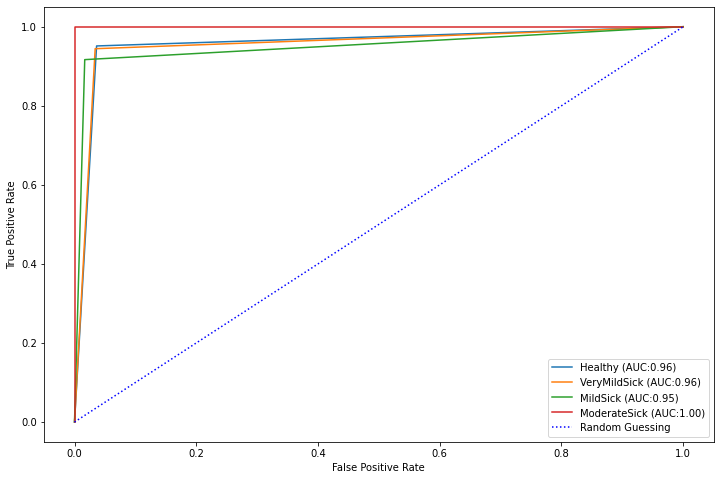

In [13]:
roc_multiclass(y_pred_vgg16_model_1,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

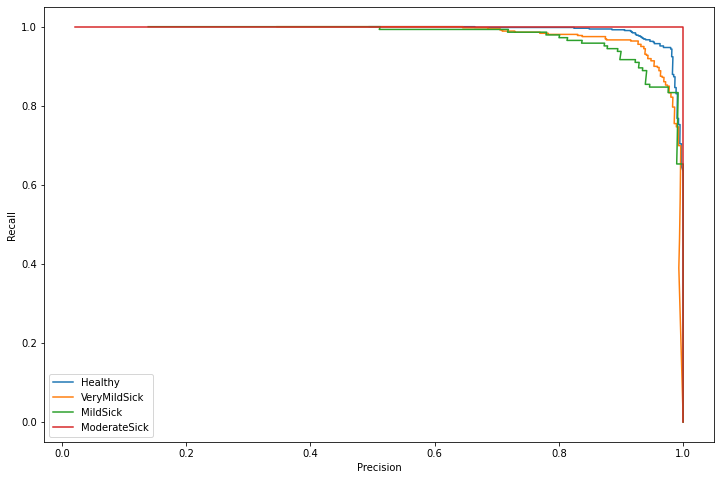

In [14]:
precision_recall_multiclass(y_pred_vgg16_model_1,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

-----
## VGG16 - 2

Custom model architecture using classification layers based on similar projects + VGG16 as backbone

In [15]:
# Defining both base and final model architecture
b_model = base_model(MODEL='VGG16', freeze_layers=True)

In [16]:
vgg16_model_2 = models.Sequential()
vgg16_model_2.add(layers.Rescaling(1./255, input_shape=(208, 176, 3)))
vgg16_model_2.add(b_model)
vgg16_model_2.add(layers.Dropout(rate=0.3))
vgg16_model_2.add(layers.Dropout(0.5))
vgg16_model_2.add(layers.Flatten())
vgg16_model_2.add(layers.BatchNormalization())
vgg16_model_2.add(layers.Dense(2048,kernel_initializer='he_uniform'))
vgg16_model_2.add(layers.BatchNormalization())
vgg16_model_2.add(layers.Activation('relu'))
vgg16_model_2.add(layers.Dropout(0.5))
vgg16_model_2.add(layers.Dense(1024,kernel_initializer='he_uniform'))
vgg16_model_2.add(layers.BatchNormalization())
vgg16_model_2.add(layers.Activation('relu'))
vgg16_model_2.add(layers.Dropout(0.5))
vgg16_model_2.add(layers.Dense(4,activation='softmax'))

vgg16_model_2.build()
vgg16_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 6, 5, 512)         0         
                                                                 
 dropout_1 (Dropout)         (None, 6, 5, 512)         0         
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 batch_normalization (BatchN  (None, 15360)            61440     
 ormalization)                                                   
                                                        

In [17]:
 # Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
vgg16_model_2.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [18]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_vgg16_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
save_best_only=True)
'''

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    vgg16_history_2 = vgg16_model_2.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True,
                        )


Epoch 1/30


2022-06-13 00:37:14.416444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 1.5390 - precision: 0.4930 - recall: 0.4282 - auc: 0.7472

2022-06-13 00:38:59.346965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 128s 980ms/step - loss: 1.5390 - precision: 0.4930 - recall: 0.4282 - auc: 0.7472 - val_loss: 1.0193 - val_precision: 0.8755 - val_recall: 0.2305 - val_auc: 0.8519
Epoch 2/30
130/130 [==============================] - 129s 995ms/step - loss: 1.0379 - precision: 0.5817 - recall: 0.4599 - auc: 0.8193 - val_loss: 0.9690 - val_precision: 0.8243 - val_recall: 0.3076 - val_auc: 0.8562
Epoch 3/30
130/130 [==============================] - 129s 990ms/step - loss: 0.9262 - precision: 0.6370 - recall: 0.5002 - auc: 0.8500 - val_loss: 0.9250 - val_precision: 0.8298 - val_recall: 0.3433 - val_auc: 0.8724
Epoch 4/30
130/130 [==============================] - 124s 954ms/step - loss: 0.8613 - precision: 0.6692 - recall: 0.5346 - auc: 0.8677 - val_loss: 0.8858 - val_precision: 0.8287 - val_recall: 0.3732 - val_auc: 0.8866
Epoch 5/30
130/130 [==============================] - 120s 925ms/step - loss: 0.7906 - precision: 0.6950 - recall: 0.5774 - auc: 0.8880 - v

In [14]:
vgg16_model_2.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/vgg16_2.h5')

In [19]:
# Make prediction on validation data set
y_pred_vgg16_model_2 = vgg16_model_2.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = vgg16_model_2.evaluate(val_ds, verbose=2)

   4/1037 [..............................] - ETA: 18s 

2022-06-13 01:38:30.260183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 25s 24ms/step
33/33 - 21s - loss: 0.2998 - precision: 0.9117 - recall: 0.8563 - auc: 0.9855 - 21s/epoch - 630ms/step


MACRO ROC AUC SCORE: 0.9443040454070769


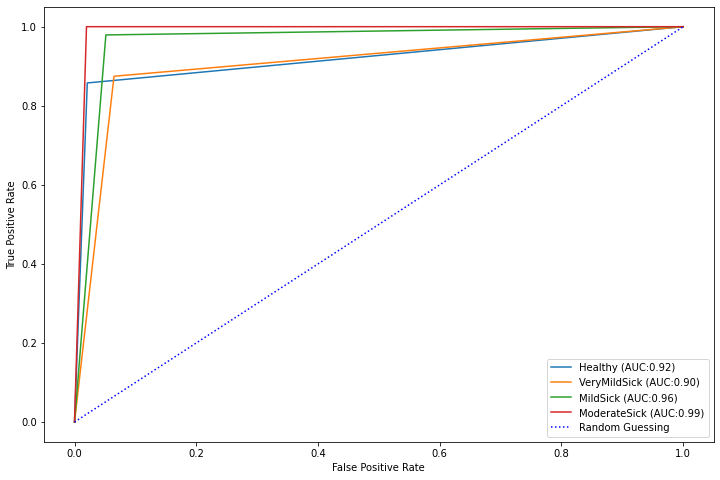

In [20]:
roc_multiclass(y_pred_vgg16_model_2,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

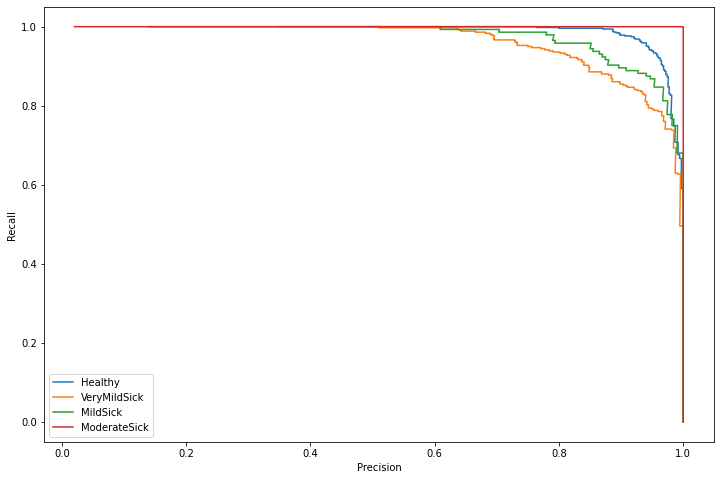

In [21]:
precision_recall_multiclass(y_pred_vgg16_model_2,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

----

## VGG16 - 3

As an optional step we now will unfreeze the entire models and re-train each of them with a very low learning rate (usually 0.0001). This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data. This is also known as fine-tuning.

In [59]:
# Defining both base and final model architecture
b_model = base_model(MODEL='VGG16', freeze_layers=False)
vgg16_model_3 = cnn_model(n_dense_layers=2, dense_layer_size=256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 256)               3932416   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 18,713,924
Trainable params: 18,713,924
Non-trainable params: 0
_________________________________________________________________


In [60]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_vgg16_3.epoch{epoch:02d}-recall{val_recall:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
save_best_only=True)
'''

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    vgg16_history_3 = vgg16_model_3.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-14 08:02:46.364697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 1.3601 - precision: 0.4785 - recall: 0.2096 - auc: 0.7535

2022-06-14 08:07:04.452582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 282s 2s/step - loss: 1.3601 - precision: 0.4785 - recall: 0.2096 - auc: 0.7535 - val_loss: 1.0580 - val_precision: 0.5499 - val_recall: 0.3934 - val_auc: 0.7967
Epoch 2/30
130/130 [==============================] - 324s 2s/step - loss: 1.0765 - precision: 0.5296 - recall: 0.2548 - auc: 0.7769 - val_loss: 1.0602 - val_precision: 0.7451 - val_recall: 0.0733 - val_auc: 0.7943
Epoch 3/30
130/130 [==============================] - 289s 2s/step - loss: 1.0437 - precision: 0.5949 - recall: 0.2788 - auc: 0.7931 - val_loss: 0.9991 - val_precision: 0.6930 - val_recall: 0.2787 - val_auc: 0.8178
Epoch 4/30
130/130 [==============================] - 306s 2s/step - loss: 0.9802 - precision: 0.6477 - recall: 0.3472 - auc: 0.8203 - val_loss: 0.9715 - val_precision: 0.6197 - val_recall: 0.4542 - val_auc: 0.8329
Epoch 5/30
130/130 [==============================] - 312s 2s/step - loss: 0.9196 - precision: 0.6756 - recall: 0.3912 - auc: 0.8421 - val_loss: 0.9168

In [12]:
vgg16_model_3.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/vgg16_3.h5')

In [61]:
# Make prediction on validation data set
y_pred_vgg16_model_3 = vgg16_model_3.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = vgg16_model_3.evaluate(val_ds, verbose=2)

2022-06-14 10:54:34.911429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 22s 20ms/step
33/33 - 18s - loss: 0.1419 - precision: 0.9691 - recall: 0.9691 - auc: 0.9930 - 18s/epoch - 545ms/step


MACRO ROC AUC SCORE: 0.9814224210180427


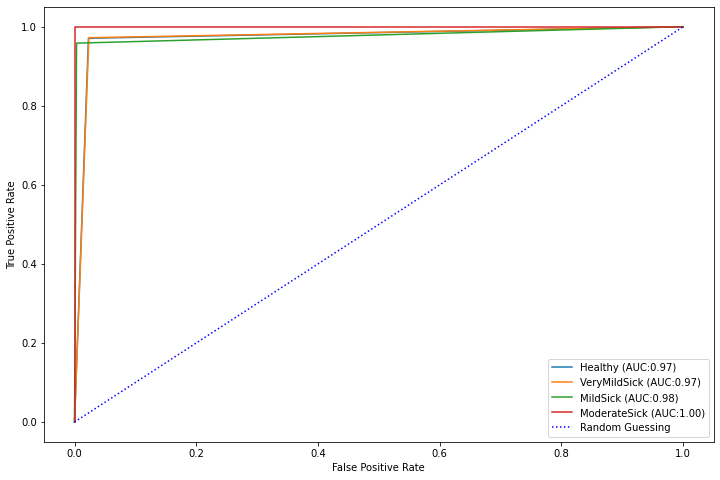

In [25]:
roc_multiclass(y_pred_vgg16_model_3,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

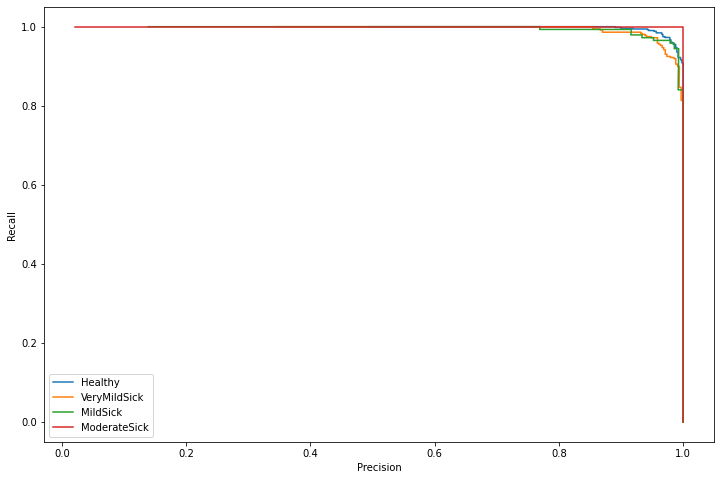

In [26]:
precision_recall_multiclass(y_pred_vgg16_model_3,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

In [62]:
# Model Evaluation
plt.plot(vgg16_history_1.history['recall'], label='vgg16_1')
plt.plot(vgg16_history_2.history['recall'], label='vgg16_2')
plt.plot(vgg16_history_3.history['recall'], label='vgg16_3')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

NameError: name 'vgg16_history_1' is not defined

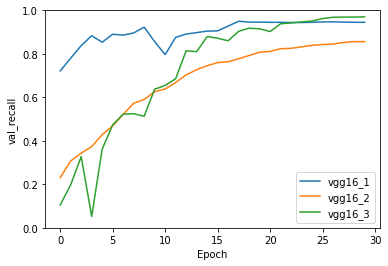

In [42]:
# Model Evaluation
plt.plot(vgg16_history_1.history['val_recall'], label='vgg16_1')
plt.plot(vgg16_history_2.history['val_recall'], label='vgg16_2')
plt.plot(vgg16_history_3.history['val_recall'], label='vgg16_3')
plt.xlabel('Epoch')
plt.ylabel('val_recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

-------
## ResNet50 - 1

Model architecture using only 2 classification layer after the backbone

In [10]:
# Defining both base and final model architecture
b_model = base_model(MODEL='ResNet50', freeze_layers=True)
resnet50_model_1 = cnn_model(n_dense_layers=1, dense_layer_size=1024)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 6, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 86016)             0         
                                                                 
 dense (Dense)               (None, 1024)              88081408  
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 111,673,220
Trainable params: 88,085,508
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_resnet50_1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='auto',
save_best_only=True)
'''

# Model training
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    resnet50_history_1 = resnet50_model_1.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-13 16:51:29.152993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 25/130 [====>.........................] - ETA: 2:02 - loss: 7.1733 - precision: 0.4526 - recall: 0.4412 - auc: 0.6930

KeyboardInterrupt: 

In [12]:
resnet50_model_1.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/restnet50_1.h5')

In [ ]:
# Make prediction on validation data set
y_pred_resnet50_model_1 = resnet50_model_1.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = resnet50_model_1.evaluate(val_ds, verbose=2)

2022-06-13 08:15:54.106043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 26s 24ms/step
33/33 - 17s - loss: 0.1698 - precision: 0.9467 - recall: 0.9412 - auc: 0.9938 - 17s/epoch - 504ms/step


MACRO ROC AUC SCORE: 0.9518097267682748


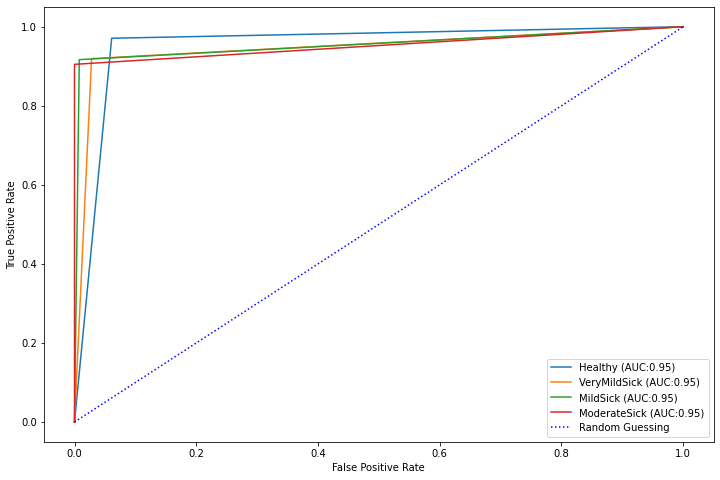

In [ ]:
roc_multiclass(y_pred_resnet50_model_1,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

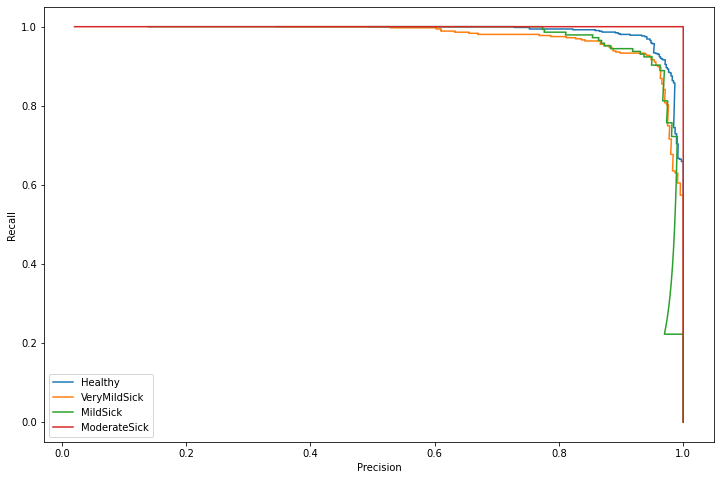

In [ ]:
precision_recall_multiclass(y_pred_resnet50_model_1,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

-------
## ResNet50 - 2 

Custom model architecture using classification layers based on similar projects + ResNet50 as backbone <br>
Template used -> https://www.kaggle.com/code/darthmanav/alzheimer-s-classification-resnet-50

In [65]:
# Defining both base and final model architecture
b_model = base_model(MODEL='ResNet50', freeze_layers=True)

In [66]:
resnet50_model_2 = models.Sequential()
resnet50_model_2.add(layers.Rescaling(1./255, input_shape=(208, 176, 3)))
resnet50_model_2.add(b_model)
resnet50_model_2.add(layers.Dropout(0.5))
resnet50_model_2.add(layers.Flatten())
resnet50_model_2.add(layers.BatchNormalization())
resnet50_model_2.add(layers.Dense(64,kernel_initializer='he_uniform'))
resnet50_model_2.add(layers.BatchNormalization())
resnet50_model_2.add(layers.Activation('relu'))
resnet50_model_2.add(layers.Dropout(0.5))
resnet50_model_2.add(layers.Dense(64,kernel_initializer='he_uniform'))
resnet50_model_2.add(layers.BatchNormalization())
resnet50_model_2.add(layers.Activation('relu'))
resnet50_model_2.add(layers.Dropout(0.5))
resnet50_model_2.add(layers.Dense(64,kernel_initializer='he_uniform'))
resnet50_model_2.add(layers.BatchNormalization())
resnet50_model_2.add(layers.Activation('relu'))
resnet50_model_2.add(layers.Dropout(0.5))
resnet50_model_2.add(layers.Dense(32,kernel_initializer='he_uniform'))
resnet50_model_2.add(layers.BatchNormalization())
resnet50_model_2.add(layers.Activation('relu'))
resnet50_model_2.add(layers.Dropout(0.5))
resnet50_model_2.add(layers.Dense(32,kernel_initializer='he_uniform'))
resnet50_model_2.add(layers.BatchNormalization())
resnet50_model_2.add(layers.Activation('relu'))
resnet50_model_2.add(layers.Dense(4,activation='softmax'))

resnet50_model_2.build()
resnet50_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 6, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 6, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 86016)             0         
                                                                 
 batch_normalization (BatchN  (None, 86016)            344064    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                5505088   
                                                        

In [67]:
 # Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
resnet50_model_2.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [68]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_resnet50_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
save_best_only=True)
'''

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    resnet50_history_2 = resnet50_model_2.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True,
                        )

Epoch 1/30


2022-06-14 10:57:29.229950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 1.2460 - precision: 0.4913 - recall: 0.0752 - auc: 0.7091

2022-06-14 10:58:50.282922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 112s 752ms/step - loss: 1.2460 - precision: 0.4913 - recall: 0.0752 - auc: 0.7091 - val_loss: 1.2816 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7446
Epoch 2/30
 18/130 [===>..........................] - ETA: 53s - loss: 1.1665 - precision: 0.5851 - recall: 0.0955 - auc: 0.7579

KeyboardInterrupt: 

In [ ]:
# Make prediction on validation data set
y_pred_resnet50_model_2 = resnet50_model_2.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = resnet50_model_2.evaluate(val_ds, verbose=2)

In [78]:
resnet50_model_2.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/restnet50_2.tf')

INFO:tensorflow:Assets written to: /Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/restnet50_2.tf/assets


In [ ]:
resnet50_model_2.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/restnet50_2.h5')

In [ ]:
roc_multiclass(y_pred_resnet50_model_2,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

In [ ]:
precision_recall_multiclass(y_pred_resnet50_model_2,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

-----
## ResNet50 - 3

In [13]:
# Defining both base and final model architecture
b_model = base_model(MODEL='ResNet50', freeze_layers=False)
resnet50_model_3 = cnn_model(n_dense_layers=2, dense_layer_size=256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 6, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 86016)             0         
                                                                 
 dense (Dense)               (None, 256)               22020352  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 45,674,884
Trainable params: 45,621,764
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_vgg16_3.epoch{epoch:02d}-recall{val_recall:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
save_best_only=True)
'''

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    resnet50_history_3 = resnet50_model_3.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-14 11:18:42.275772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 0.7699 - precision: 0.7378 - recall: 0.6526 - auc: 0.9052

2022-06-14 11:21:16.622768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 177s 1s/step - loss: 0.7699 - precision: 0.7378 - recall: 0.6526 - auc: 0.9052 - val_loss: 0.8687 - val_precision: 0.6342 - val_recall: 0.5902 - val_auc: 0.8851
Epoch 2/30
130/130 [==============================] - 298s 2s/step - loss: 0.1278 - precision: 0.9559 - recall: 0.9475 - auc: 0.9968 - val_loss: 1.0404 - val_precision: 0.6987 - val_recall: 0.6798 - val_auc: 0.8986
Epoch 3/30
130/130 [==============================] - 310s 2s/step - loss: 0.0874 - precision: 0.9697 - recall: 0.9674 - auc: 0.9981 - val_loss: 4.5593 - val_precision: 0.5265 - val_recall: 0.5265 - val_auc: 0.7453
Epoch 4/30
130/130 [==============================] - 303s 2s/step - loss: 0.0910 - precision: 0.9695 - recall: 0.9671 - auc: 0.9975 - val_loss: 1.6082 - val_precision: 0.6647 - val_recall: 0.6615 - val_auc: 0.8724
Epoch 5/30
130/130 [==============================] - 288s 2s/step - loss: 0.0444 - precision: 0.9836 - recall: 0.9833 - auc: 0.9994 - val_loss: 5.8947

In [15]:
resnet50_model_3.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/restnet50_3.h5')

In [16]:
# Make prediction on validation data set
y_pred_resnet50_model_3 = resnet50_model_3.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = resnet50_model_3.evaluate(val_ds, verbose=2)

2022-06-14 13:35:41.148579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 28s 25ms/step
33/33 - 17s - loss: 0.0456 - precision: 0.9875 - recall: 0.9875 - auc: 0.9981 - 17s/epoch - 530ms/step


MACRO ROC AUC SCORE: 0.991952393721555


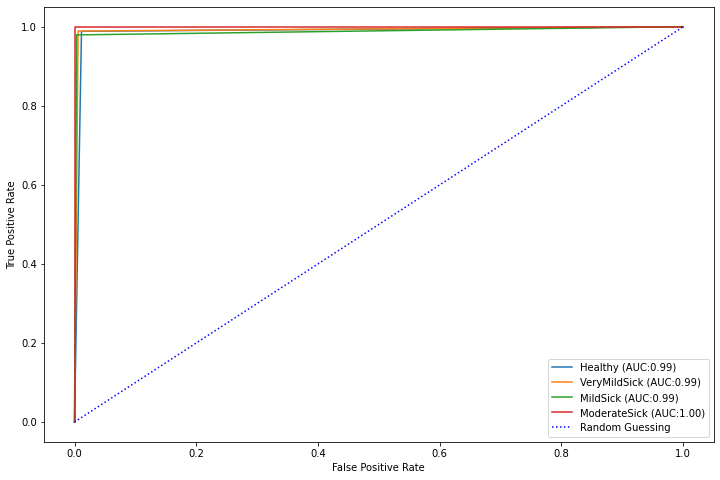

In [17]:
roc_multiclass(y_pred_resnet50_model_3,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

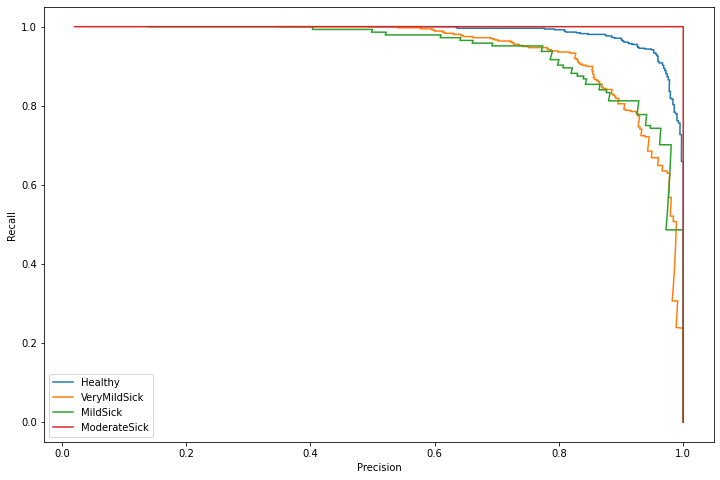

In [40]:
precision_recall_multiclass(y_pred_resnet50_model_3,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

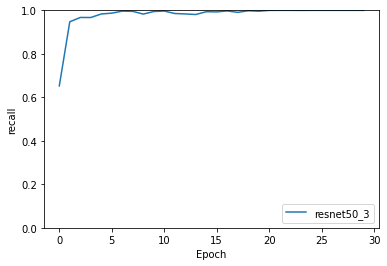

In [20]:
# Model Evaluation
#plt.plot(resnet50_history_1.history['recall'], label='resnet50_1')
#plt.plot(resnet50_history_2.history['recall'], label='resnet50_2')
plt.plot(resnet50_history_3.history['recall'], label='resnet50_3')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

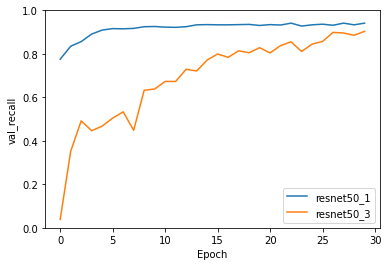

In [46]:
# Model Evaluation
plt.plot(resnet50_history_1.history['val_recall'], label='resnet50_1')
#plt.plot(resnet50_history_2.history['val_recall'], label='resnet50_2')
plt.plot(resnet50_history_3.history['val_recall'], label='resnet50_3')
plt.xlabel('Epoch')
plt.ylabel('val_recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

---------------

## InceptionV3 - 1

In [12]:
# Defining both base and final model architecture
b_model = base_model(MODEL='InceptionV3', freeze_layers=True)
inceptionv3_model_1 = cnn_model(n_dense_layers=1, dense_layer_size=1024)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 4, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 40960)             0         
                                                                 
 dense (Dense)               (None, 1024)              41944064  
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 63,750,948
Trainable params: 41,948,164
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_inceptionv3_model_1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='auto',
save_best_only=True)
'''

# Model training
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    inceptionv3_history_1 = inceptionv3_model_1.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-13 18:21:24.469839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 36.4207 - precision: 0.5080 - recall: 0.5077 - auc: 0.6893

2022-06-13 18:21:56.956311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 42s 299ms/step - loss: 36.4207 - precision: 0.5080 - recall: 0.5077 - auc: 0.6893 - val_loss: 7.4547 - val_precision: 0.5866 - val_recall: 0.5844 - val_auc: 0.7498
Epoch 2/30
130/130 [==============================] - 36s 279ms/step - loss: 8.5536 - precision: 0.5810 - recall: 0.5808 - auc: 0.7482 - val_loss: 16.1010 - val_precision: 0.5425 - val_recall: 0.5419 - val_auc: 0.7043
Epoch 3/30
130/130 [==============================] - 41s 311ms/step - loss: 5.4232 - precision: 0.6504 - recall: 0.6494 - auc: 0.8014 - val_loss: 3.2791 - val_precision: 0.6972 - val_recall: 0.6972 - val_auc: 0.8377
Epoch 4/30
130/130 [==============================] - 50s 387ms/step - loss: 4.6097 - precision: 0.6750 - recall: 0.6743 - auc: 0.8152 - val_loss: 13.8242 - val_precision: 0.4494 - val_recall: 0.4494 - val_auc: 0.6473
Epoch 5/30
130/130 [==============================] - 52s 397ms/step - loss: 3.0150 - precision: 0.7372 - recall: 0.7353 - auc: 0.8651 - val

In [ ]:
inceptionv3_model_1.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/inceptionv3_1.h5')

In [14]:
# Make prediction on validation data set
y_pred_inceptionv3_model_1 = inceptionv3_model_1.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = inceptionv3_model_1.evaluate(val_ds, verbose=2)

2022-06-13 18:45:07.351268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 24s 22ms/step
33/33 - 8s - loss: 18.8159 - precision: 0.6091 - recall: 0.6085 - auc: 0.7471 - 8s/epoch - 252ms/step


MACRO ROC AUC SCORE: 0.7330597598565125


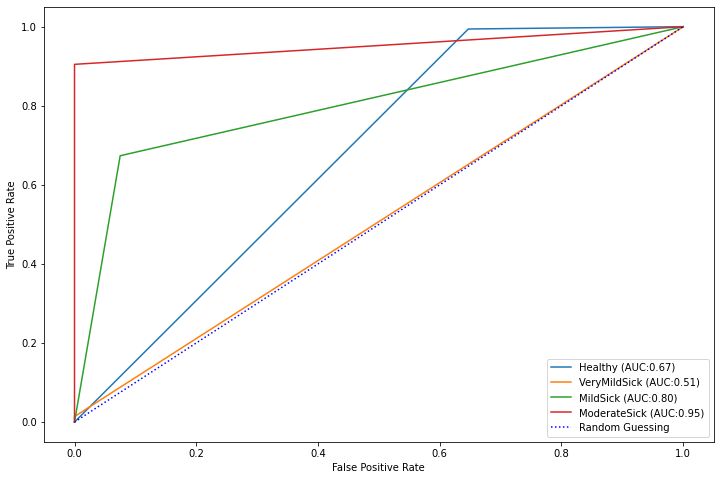

In [15]:
roc_multiclass(y_pred_inceptionv3_model_1,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

ValueError: Found input variables with inconsistent numbers of samples: [1037, 1018]

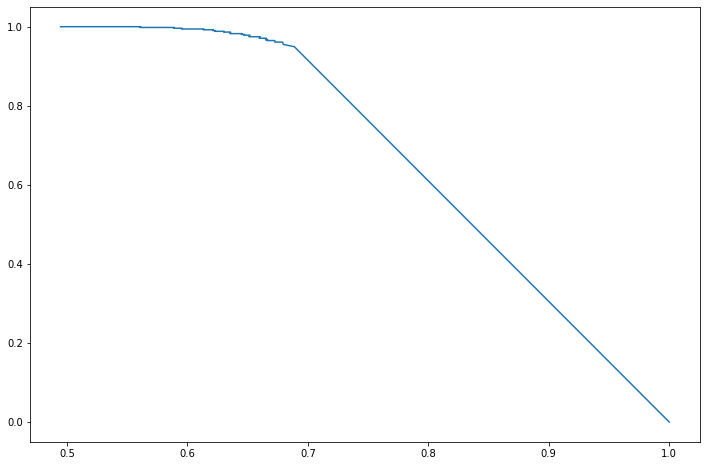

In [18]:
precision_recall_multiclass(y_pred_inceptionv3_model_1,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

-------
## InceptionV3 - 2

Custom model architecture using classification layers based on similar projects + InceptionV3 as backbone <br>
Template used -> 

In [28]:
# Defining both base and final model architecture
b_model = base_model(MODEL='InceptionV3', freeze_layers=True)

In [11]:

inceptionv3_model_2 = models.Sequential()
inceptionv3_model_2.add(layers.Rescaling(1./255, input_shape=(208, 176, 3)))
inceptionv3_model_2.add(b_model)
inceptionv3_model_2.add(layers.Dropout(0.5))
inceptionv3_model_2.add(layers.GlobalAveragePooling2D())
inceptionv3_model_2.add(layers.Flatten())
inceptionv3_model_2.add(layers.BatchNormalization())
inceptionv3_model_2.add(layers.Dense(512,activation='relu'))
inceptionv3_model_2.add(layers.BatchNormalization())
inceptionv3_model_2.add(layers.Dropout(0.5))
inceptionv3_model_2.add(layers.Dense(256,activation='relu'))
inceptionv3_model_2.add(layers.BatchNormalization())
inceptionv3_model_2.add(layers.Dropout(0.5))
inceptionv3_model_2.add(layers.Dense(128,activation='relu'))
inceptionv3_model_2.add(layers.BatchNormalization())
inceptionv3_model_2.add(layers.Dropout(0.5))
inceptionv3_model_2.add(layers.Dense(64,activation='relu'))
inceptionv3_model_2.add(layers.Dropout(0.5))
inceptionv3_model_2.add(layers.BatchNormalization())
inceptionv3_model_2.add(layers.Dense(4,activation='softmax'))

inceptionv3_model_2.build()
inceptionv3_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 6, 5, 1920)        0         
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                          

In [12]:
 # Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
inceptionv3_model_2.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [31]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_inceptionv3_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='auto',
save_best_only=True)
'''

# Model training
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    inceptionv3_history_2 = inceptionv3_model_2.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-13 20:01:18.486117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 1.7553 - precision: 0.2472 - recall: 0.1356 - auc: 0.5242

2022-06-13 20:01:41.654707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 32s 214ms/step - loss: 1.7553 - precision: 0.2472 - recall: 0.1356 - auc: 0.5242 - val_loss: 1.4419 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4945
Epoch 2/30
130/130 [==============================] - 26s 201ms/step - loss: 1.5599 - precision: 0.3205 - recall: 0.1530 - auc: 0.5749 - val_loss: 1.4174 - val_precision: 0.4667 - val_recall: 0.0068 - val_auc: 0.5494
Epoch 3/30
130/130 [==============================] - 31s 238ms/step - loss: 1.4314 - precision: 0.4088 - recall: 0.1934 - auc: 0.6278 - val_loss: 1.3516 - val_precision: 0.5357 - val_recall: 0.0289 - val_auc: 0.6071
Epoch 4/30
130/130 [==============================] - 31s 237ms/step - loss: 1.3716 - precision: 0.4550 - recall: 0.2089 - auc: 0.6535 - val_loss: 1.2865 - val_precision: 0.6034 - val_recall: 0.0338 - val_auc: 0.6649
Epoch 5/30
130/130 [==============================] - 32s 246ms/step - loss: 1.3017 - precision: 0.5051 - recall: 0.2265 - auc: 0.6822 

In [17]:
inceptionv3_model_2.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/inceptionv3_2.h5')

In [32]:
# Make prediction on validation data set
y_pred_inceptionv3_model_2 = inceptionv3_model_2.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = inceptionv3_model_2.evaluate(val_ds, verbose=2)

2022-06-13 20:18:58.010389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 23s 20ms/step
33/33 - 5s - loss: 0.8538 - precision: 0.6547 - recall: 0.5082 - auc: 0.8718 - 5s/epoch - 155ms/step


MACRO ROC AUC SCORE: 0.6208964792483113


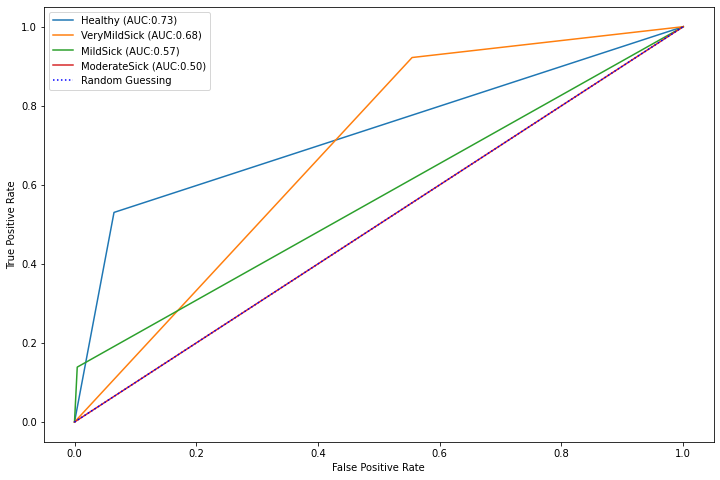

In [33]:
roc_multiclass(y_pred_inceptionv3_model_2,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

IndexError: index 3 is out of bounds for axis 1 with size 3

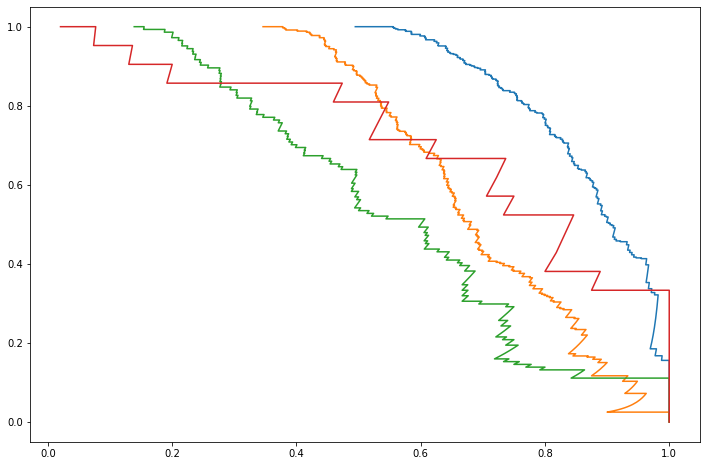

In [34]:
precision_recall_multiclass(y_pred_inceptionv3_model_2,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

------
## InceptionV3 - 3

In [35]:
# Defining both base and final model architecture
b_model = base_model(MODEL='InceptionV3', freeze_layers=False)
inceptionv3_model_3 = cnn_model(n_dense_layers=2, dense_layer_size=256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 4, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 40960)             0         
                                                                 
 dense (Dense)               (None, 256)               10486016  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 32,355,620
Trainable params: 32,321,188
Non-trainable params: 34,432
_________________________________________________________________


In [36]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_vgg16_3.epoch{epoch:02d}-recall{val_recall:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='max',
save_best_only=True)
'''

# Model training. Model weights are saved at the end of every epoch, if it's the best seen so far
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    inceptionv3_history_3 = inceptionv3_model_3.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-13 20:43:51.787419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 0.8571 - precision: 0.7466 - recall: 0.6163 - auc: 0.8941

2022-06-13 20:45:22.810946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 102s 732ms/step - loss: 0.8571 - precision: 0.7466 - recall: 0.6163 - auc: 0.8941 - val_loss: 0.8406 - val_precision: 0.6972 - val_recall: 0.6461 - val_auc: 0.8987
Epoch 2/30
130/130 [==============================] - 99s 755ms/step - loss: 0.2485 - precision: 0.9148 - recall: 0.8960 - auc: 0.9883 - val_loss: 0.3077 - val_precision: 0.8886 - val_recall: 0.8843 - val_auc: 0.9845
Epoch 3/30
130/130 [==============================] - 101s 772ms/step - loss: 0.0840 - precision: 0.9726 - recall: 0.9691 - auc: 0.9982 - val_loss: 0.3975 - val_precision: 0.8880 - val_recall: 0.8795 - val_auc: 0.9776
Epoch 4/30
130/130 [==============================] - 110s 848ms/step - loss: 0.0660 - precision: 0.9777 - recall: 0.9770 - auc: 0.9986 - val_loss: 0.0954 - val_precision: 0.9710 - val_recall: 0.9672 - val_auc: 0.9962
Epoch 5/30
130/130 [==============================] - 120s 924ms/step - loss: 0.0452 - precision: 0.9867 - recall: 0.9860 - auc: 0.9991 - va

In [13]:
inceptionv3_model_3.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/inceptionv3_3.h5')

In [37]:
# Make prediction on validation data set
y_pred_inceptionv3_model_3 = inceptionv3_model_3.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = inceptionv3_model_3.evaluate(val_ds, verbose=2)

2022-06-13 21:51:08.766780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 23s 20ms/step
33/33 - 8s - loss: 0.1770 - precision: 0.9547 - recall: 0.9547 - auc: 0.9915 - 8s/epoch - 252ms/step


MACRO ROC AUC SCORE: 0.9682146430872955


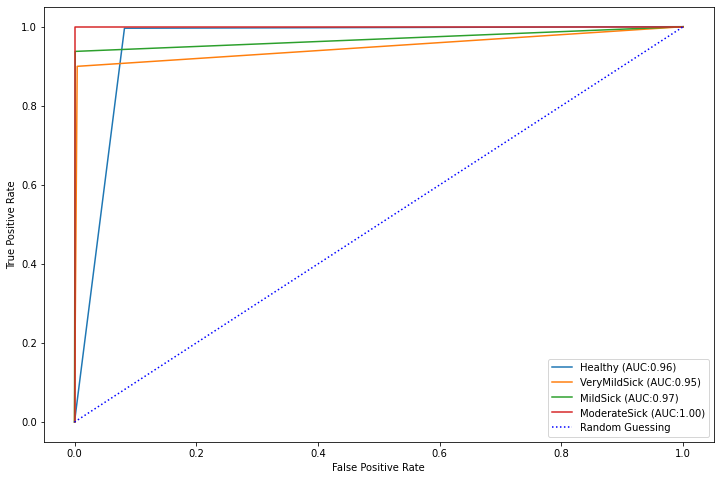

In [38]:
roc_multiclass(y_pred_inceptionv3_model_3,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

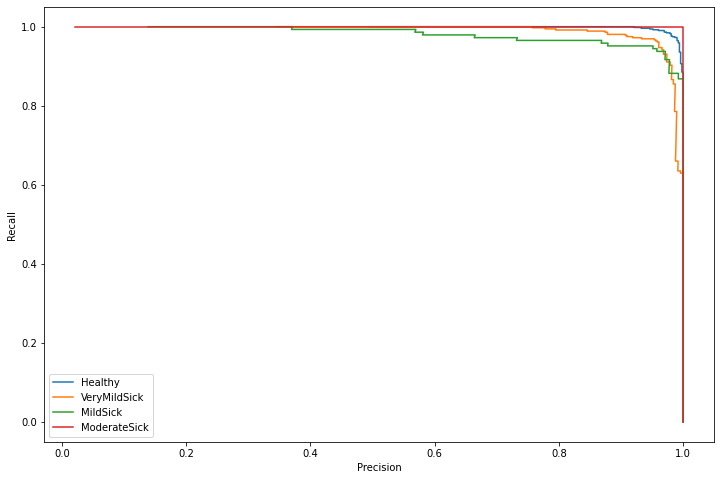

In [ ]:
precision_recall_multiclass(y_pred_inceptionv3_model_3,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

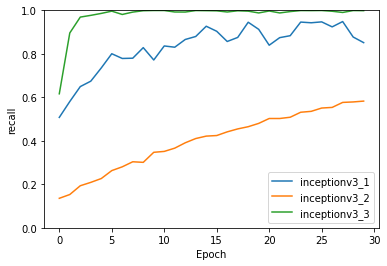

In [39]:
# Model Evaluation
plt.plot(inceptionv3_history_1.history['recall'], label='inceptionv3_1')
plt.plot(inceptionv3_history_2.history['recall'], label='inceptionv3_2')
plt.plot(inceptionv3_history_3.history['recall'], label='inceptionv3_3')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

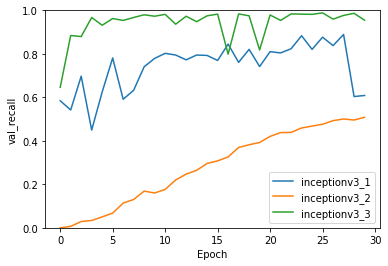

In [40]:
# Model Evaluation
plt.plot(inceptionv3_history_1.history['val_recall'], label='inceptionv3_1')
plt.plot(inceptionv3_history_2.history['val_recall'], label='inceptionv3_2')
plt.plot(inceptionv3_history_3.history['val_recall'], label='inceptionv3_3')
plt.xlabel('Epoch')
plt.ylabel('val_recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

-------
## DenseNet201 - 1
DenseNet requires heavy GPU memory due to concatenation operations. The main reason that DenseNet requires more training time is that DenseNet uses many small convolutions in the network, which runs slower on GPU than compact large convolution with the same number of GFLOPS

In [41]:
b_model = tf.keras.applications.DenseNet201(include_top=False, weights="imagenet", input_shape=(208, 176, 3), classes=4)
for layer in b_model.layers:
            layer.trainable = False
densenet201_model_1 = cnn_model(n_dense_layers=1, dense_layer_size=1024)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 1024)              58983424  
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 77,309,508
Trainable params: 58,987,524
Non-trainable params: 18,321,984
_________________________________________________________________


In [42]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_densenet201_1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='auto',
save_best_only=True)
'''

# Model training
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    densenet201_history_1 = densenet201_model_1.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-13 22:19:55.192930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 5.8711 - precision: 0.5932 - recall: 0.5740 - auc: 0.7935

2022-06-13 22:21:19.671111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 114s 807ms/step - loss: 5.8711 - precision: 0.5932 - recall: 0.5740 - auc: 0.7935 - val_loss: 1.3814 - val_precision: 0.5370 - val_recall: 0.5246 - val_auc: 0.8406
Epoch 2/30
130/130 [==============================] - 115s 882ms/step - loss: 0.5050 - precision: 0.8197 - recall: 0.7858 - auc: 0.9546 - val_loss: 0.5078 - val_precision: 0.8277 - val_recall: 0.7599 - val_auc: 0.9540
Epoch 3/30
130/130 [==============================] - 121s 918ms/step - loss: 0.3223 - precision: 0.8951 - recall: 0.8624 - auc: 0.9819 - val_loss: 0.5851 - val_precision: 0.7452 - val_recall: 0.7165 - val_auc: 0.9403
Epoch 4/30
130/130 [==============================] - 118s 906ms/step - loss: 0.2483 - precision: 0.9278 - recall: 0.9004 - auc: 0.9905 - val_loss: 0.5049 - val_precision: 0.7963 - val_recall: 0.7541 - val_auc: 0.9554
Epoch 5/30
130/130 [==============================] - 125s 963ms/step - loss: 0.1861 - precision: 0.9545 - recall: 0.9383 - auc: 0.9960 - v

In [12]:
densenet201_model_1.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/densenet201_1.h5')

In [43]:
# Make prediction on validation data set
y_pred_densenet201_model_1 = densenet201_model_1.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = densenet201_model_1.evaluate(val_ds, verbose=2)

2022-06-13 23:13:49.829704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 53s 46ms/step
33/33 - 19s - loss: 0.1672 - precision: 0.9475 - recall: 0.9392 - auc: 0.9940 - 19s/epoch - 584ms/step


MACRO ROC AUC SCORE: 0.9611734709528528


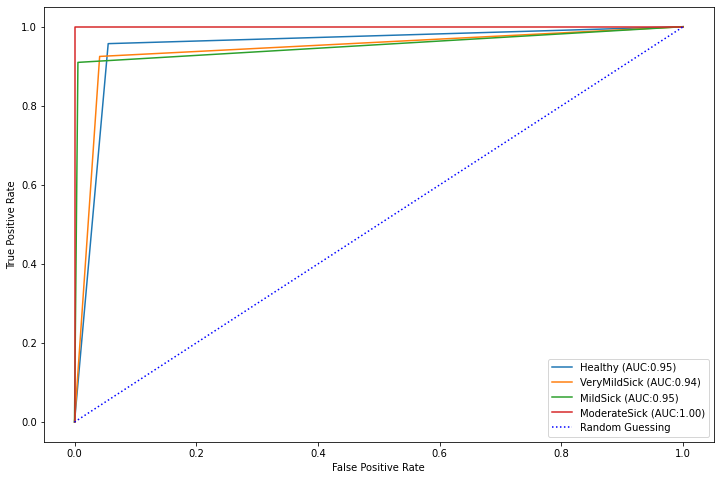

In [44]:
roc_multiclass(y_pred_densenet201_model_1,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

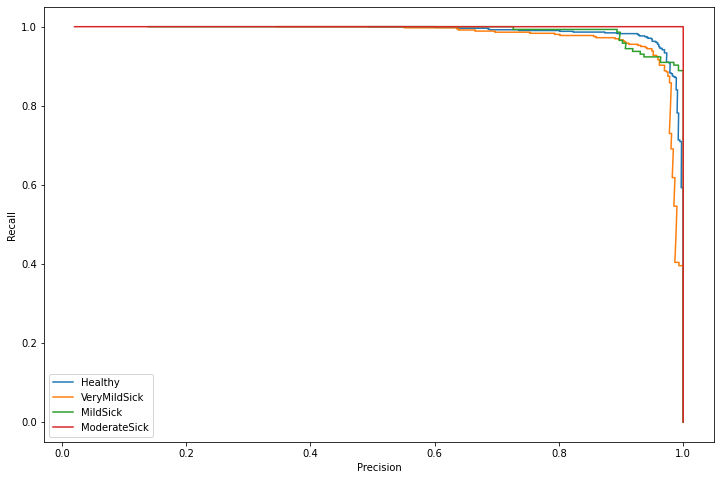

In [15]:
precision_recall_multiclass(y_pred_densenet201_model_1,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

-------
## DenseNet201 - 2

Custom model architecture using classification layers based on similar projects + ResNet50 as backbone <br>
Template used -> https://www.kaggle.com/code/gauravrajpal/alzheimer-s-classification-densenet201-auc-86-56

In [10]:
# Defining both base and final model architecture
b_model = base_model(MODEL='DenseNet201', freeze_layers=True)

In [12]:
b_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 208, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 214, 182, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 104, 88, 64)  9408        ['zero_padding2d_2[0][0]']       
                                                                                        

In [13]:
b_model = tf.keras.applications.DenseNet201(include_top=False, weights="imagenet", input_shape=(208, 176, 3), classes=4)
for layer in b_model.layers:
            layer.trainable = False

In [14]:
densenet201_model_2 = models.Sequential()
densenet201_model_2.add(layers.Rescaling(1./255, input_shape=(208, 176, 3)))
densenet201_model_2.add(b_model)
densenet201_model_2.add(layers.Dropout(0.5))
densenet201_model_2.add(layers.Flatten())
densenet201_model_2.add(layers.BatchNormalization())
densenet201_model_2.add(layers.Dense(2048,kernel_initializer='he_uniform'))
densenet201_model_2.add(layers.BatchNormalization())
densenet201_model_2.add(layers.Activation('relu'))
densenet201_model_2.add(layers.Dropout(0.5))
densenet201_model_2.add(layers.Dense(1024,kernel_initializer='he_uniform'))
densenet201_model_2.add(layers.BatchNormalization())
densenet201_model_2.add(layers.Activation('relu'))
densenet201_model_2.add(layers.Dropout(0.5))
densenet201_model_2.add(layers.Dense(4,activation='softmax'))

densenet201_model_2.build()
densenet201_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 208, 176, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 dropout (Dropout)           (None, 6, 5, 1920)        0         
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 batch_normalization (BatchN  (None, 57600)            230400    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              117966848 
                                                        

In [15]:
 # Freeze the the behavior of that model. If any trainable value changes, compile() must be called again
keras.backend.clear_session()
densenet201_model_2.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [48]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_densenet201_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='auto',
save_best_only=True)
'''

# Model training
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    densenet201_history_2 = densenet201_model_2.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )


Epoch 1/30


2022-06-13 23:15:15.580789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 1.4073 - precision: 0.5076 - recall: 0.4335 - auc: 0.7591

2022-06-13 23:17:13.171902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 152s 1s/step - loss: 1.4073 - precision: 0.5076 - recall: 0.4335 - auc: 0.7591 - val_loss: 1.0993 - val_precision: 0.7855 - val_recall: 0.3144 - val_auc: 0.7711
Epoch 2/30
130/130 [==============================] - 170s 1s/step - loss: 1.0031 - precision: 0.6022 - recall: 0.4952 - auc: 0.8334 - val_loss: 1.0009 - val_precision: 0.8582 - val_recall: 0.3211 - val_auc: 0.8288
Epoch 3/30
130/130 [==============================] - 183s 1s/step - loss: 0.8980 - precision: 0.6477 - recall: 0.5382 - auc: 0.8601 - val_loss: 0.9740 - val_precision: 0.8353 - val_recall: 0.3472 - val_auc: 0.8380
Epoch 4/30
130/130 [==============================] - 162s 1s/step - loss: 0.7912 - precision: 0.6886 - recall: 0.5774 - auc: 0.8884 - val_loss: 0.9317 - val_precision: 0.8299 - val_recall: 0.3905 - val_auc: 0.8520
Epoch 5/30
130/130 [==============================] - 148s 1s/step - loss: 0.7136 - precision: 0.7230 - recall: 0.6216 - auc: 0.9084 - val_loss: 0.8790

In [14]:
densenet201_model_2.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/densenet201_2.h5')

In [49]:
# Make prediction on validation data set
y_pred_densenet201_model_2 = densenet201_model_2.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = densenet201_model_2.evaluate(val_ds, verbose=2)

2022-06-14 00:26:21.059271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 73s 65ms/step
33/33 - 22s - loss: 0.2282 - precision: 0.9409 - recall: 0.9065 - auc: 0.9915 - 22s/epoch - 654ms/step


MACRO ROC AUC SCORE: 0.9600476678192089


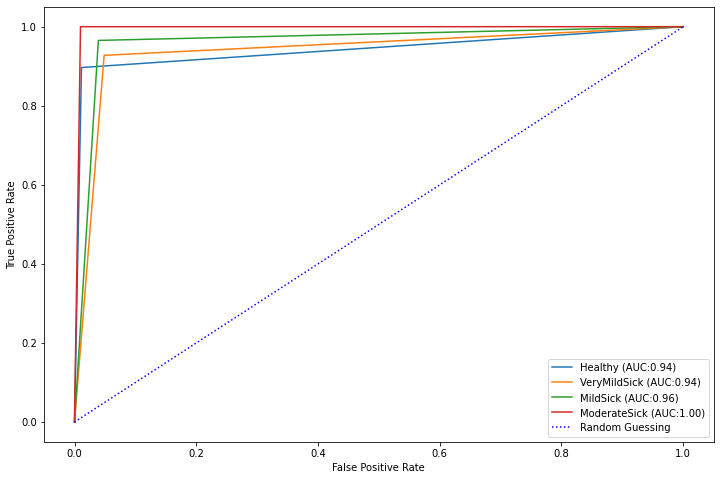

In [50]:
roc_multiclass(y_pred_densenet201_model_2,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

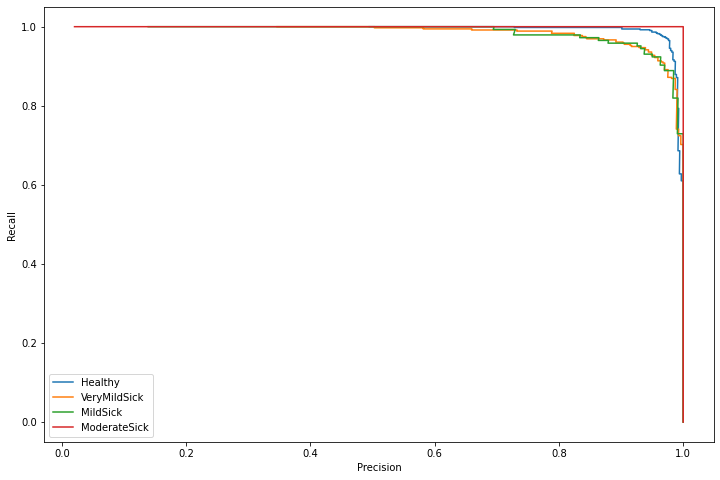

In [17]:
precision_recall_multiclass(y_pred_densenet201_model_2,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

-------
## DenseNet201 - 3

In [51]:
b_model = tf.keras.applications.DenseNet201(include_top=False, weights="imagenet", input_shape=(208, 176, 3), classes=4)
for layer in b_model.layers:
            layer.trainable = True
densenet201_model_3 = cnn_model(n_dense_layers=2, dense_layer_size=256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 6, 5, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 256)               14745856  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 33,134,660
Trainable params: 32,905,604
Non-trainable params: 229,056
_________________________________________________________________


In [52]:
'''
# Saving model parameters and weights per epoch
checkpoint_filepath = '/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_densenet201_3'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_recall', mode='auto',
save_best_only=True)
'''

# Model training
with tf.device("/gpu:0"):
    tf.random.set_seed(10)
    densenet201_history_3 = densenet201_model_3.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=30, 
                        shuffle=True
                        )

Epoch 1/30


2022-06-14 00:28:54.527725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - ETA: 0s - loss: 0.7856 - precision: 0.7358 - recall: 0.6175 - auc: 0.9023

2022-06-14 00:36:44.284767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


130/130 [==============================] - 508s 4s/step - loss: 0.7856 - precision: 0.7358 - recall: 0.6175 - auc: 0.9023 - val_loss: 0.9076 - val_precision: 0.6562 - val_recall: 0.6239 - val_auc: 0.9044
Epoch 2/30
130/130 [==============================] - 564s 4s/step - loss: 0.1839 - precision: 0.9403 - recall: 0.9284 - auc: 0.9935 - val_loss: 0.3445 - val_precision: 0.8844 - val_recall: 0.8775 - val_auc: 0.9795
Epoch 3/30
130/130 [==============================] - 570s 4s/step - loss: 0.0681 - precision: 0.9799 - recall: 0.9778 - auc: 0.9988 - val_loss: 0.1275 - val_precision: 0.9564 - val_recall: 0.9518 - val_auc: 0.9945
Epoch 4/30
130/130 [==============================] - 518s 4s/step - loss: 0.0400 - precision: 0.9869 - recall: 0.9862 - auc: 0.9991 - val_loss: 0.8085 - val_precision: 0.7512 - val_recall: 0.7367 - val_auc: 0.9254
Epoch 5/30
130/130 [==============================] - 558s 4s/step - loss: 0.0196 - precision: 0.9940 - recall: 0.9935 - auc: 0.9999 - val_loss: 0.1006

In [53]:
densenet201_model_3.save('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/densenet201_3.h5')

ValueError: Unable to create dataset (name already exists)

In [54]:
# Make prediction on validation data set
y_pred_densenet201_model_3 = densenet201_model_3.predict(X_val, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = densenet201_model_3.evaluate(val_ds, verbose=2)

2022-06-14 07:53:35.341852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1037/1037 [==============================] - 66s 55ms/step
33/33 - 18s - loss: 0.1785 - precision: 0.9527 - recall: 0.9518 - auc: 0.9905 - 18s/epoch - 537ms/step


MACRO ROC AUC SCORE: 0.969061990783116


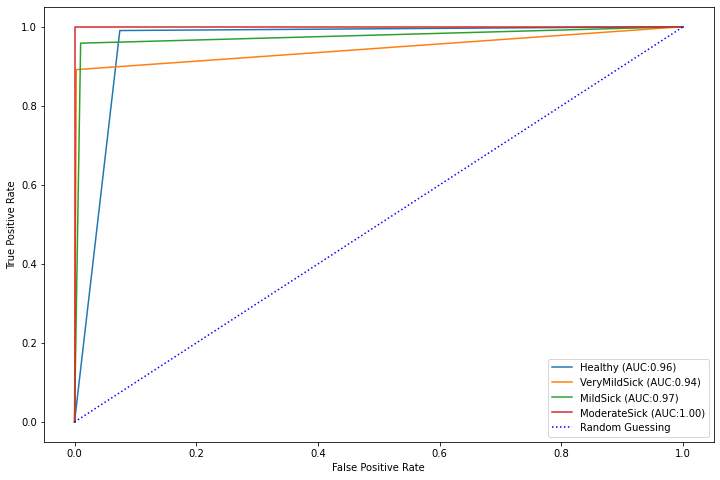

In [55]:
roc_multiclass(y_pred_densenet201_model_3,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

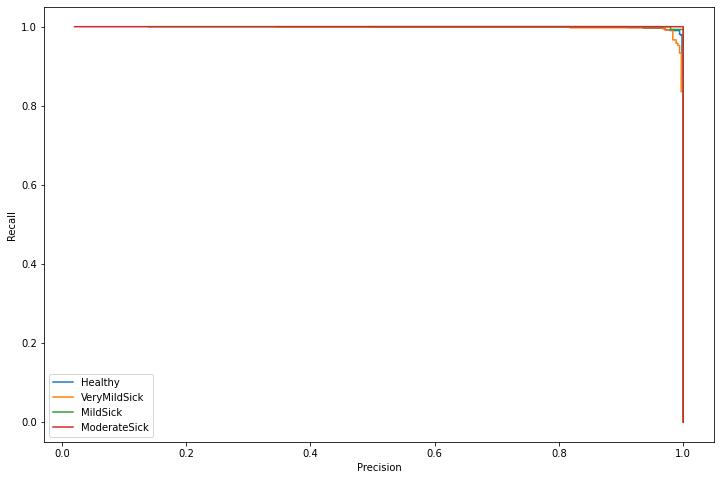

In [15]:
precision_recall_multiclass(y_pred_densenet201_model_3,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

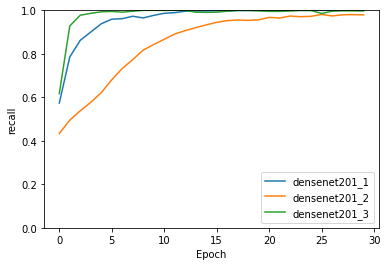

In [56]:
# Model Evaluation
plt.plot(densenet201_history_1.history['recall'], label='densenet201_1')
plt.plot(densenet201_history_2.history['recall'], label='densenet201_2')
plt.plot(densenet201_history_3.history['recall'], label='densenet201_3')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

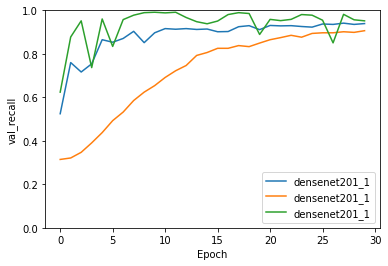

In [57]:
# Model Evaluation
plt.plot(densenet201_history_1.history['val_recall'], label='densenet201_1')
plt.plot(densenet201_history_2.history['val_recall'], label='densenet201_1')
plt.plot(densenet201_history_3.history['val_recall'], label='densenet201_1')
plt.xlabel('Epoch')
plt.ylabel('val_recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## Models evaluation

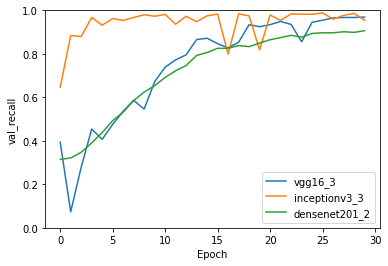

In [64]:
# Model Evaluation
plt.plot(vgg16_history_3.history['val_recall'], label='vgg16_3')
#plt.plot(resnet50_history_3.history['val_recall'], label='resnet50_3')
plt.plot(inceptionv3_history_3.history['val_recall'], label='inceptionv3_3')
plt.plot(densenet201_history_2.history['val_recall'], label='densenet201_2')

plt.xlabel('Epoch')
plt.ylabel('val_recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [2]:
vgg16_1 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/vgg16_1.h5')
vgg16_2 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/vgg16_2.h5')
vgg16_3 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/vgg16_3.h5')

2022-06-12 22:59:08.187903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-12 22:59:08.188395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



## Test on Oasis test DataSet

As a double-check we now introduce another DataSet from oasis.org to evaluate our above trained model architectures. For this, we only use the model with best performance. 

In [31]:
# Import data set as numpy arrays using the file load_oasis_set.py
from load_oasis_set import load_oasis_set
import cv2

In [32]:
X_test_oasis, y_test_oasis = load_oasis_set()



Image Array Shape: (231, 208, 176, 3) 

Image Count: 231 

labels: [0. 1. 2. 3.] 

Class Counts:
      ID
CDR     
0.0  131
1.0   70
2.0   28
3.0    2


In [29]:
for i in X_test_oasis:
    cv2.flip(i,0)

In [33]:

cv2.imshow('ajui', X_test_oasis[2])
cv2.waitKey(1)

-1

In [59]:
# one hot encode the labels to fit into the cnn layers
y_test_oasis = tf.one_hot(y_test_oasis, depth=4)

### VGG16

In [60]:
# Make prediction on test data set
y_pred_vgg12_oasis_1 = vgg16_1.predict(X_test_oasis, batch_size=1, verbose=2)
test_loss, test_prec, test_rec, test_auc  = vgg16_1.evaluate(X_test_oasis, y_test_oasis, verbose=1)

231/231 - 5s - 5s/epoch - 20ms/step
8/8 [==============================] - 4s 424ms/step - loss: 4.6869 - precision: 0.5108 - recall: 0.5108 - auc: 0.7424


In [61]:
# Make prediction on test data set
y_pred_vgg12_oasis_2 = vgg16_2.predict(X_test_oasis, batch_size=1, verbose=2)
test_loss, test_prec, test_rec, test_auc  = vgg16_2.evaluate(X_test_oasis, y_test_oasis, verbose=1)

231/231 - 5s - 5s/epoch - 21ms/step
8/8 [==============================] - 4s 430ms/step - loss: 2.4671 - precision: 0.5639 - recall: 0.5541 - auc: 0.7760


In [62]:
# Make prediction on test data set
y_pred_vgg12_oasis_3 = vgg16_3.predict(X_test_oasis, batch_size=1, verbose=2)
test_loss, test_prec, test_rec, test_auc  = vgg16_3.evaluate(X_test_oasis, y_test_oasis, verbose=1)

2022-06-12 22:13:31.173991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


231/231 - 5s - 5s/epoch - 21ms/step


2022-06-12 22:13:36.205746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 5s 449ms/step - loss: 4.0206 - precision: 0.5844 - recall: 0.5844 - auc: 0.7504


In [ ]:
#test
test = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_vgg16_2')
test_loss, test_prec, test_rec, test_auc  = test.evaluate(X_test_oasis, y_test_oasis, verbose=1)

### ResNet50

In [ ]:

resnet50_model_1 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_resnet50_model_1')
resnet50_model_2 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_resnet50_model_2')
resnet50_model_3 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_resnet50_model_3')

In [ ]:
resnet50_model_2.summary()

In [ ]:
# Make prediction on test data set
y_pred_resnet50_oasis_1 = resnet50_model_1.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = resnet50_model_1.evaluate(X_test_oasis, y_test_oasis, verbose=1)

In [ ]:
# Make prediction on test data set
y_pred_resnet50_oasis_2 = resnet50_model_2.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = resnet50_model_2.evaluate(X_test_oasis, y_test_oasis, verbose=1)

In [ ]:
test_2 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_resnet50_2')
# Make prediction on test data set
#test_2 = resnet50_model_2.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = test_2.evaluate(X_test_oasis, y_test_oasis, verbose=1)

In [ ]:
# Make prediction on test data set
y_pred_resnet50_oasis_3 = resnet50_model_3.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = resnet50_model_3.evaluate(X_test_oasis, y_test_oasis, verbose=1)

### inceptionV3

In [ ]:
inceptionV3_model_1 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_inceptionV3_1')
inceptionV3_model_2 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_inceptionV3_2')
inceptionV3_model_2 = tf.keras.models.load_model('/Users/josealbertodiazsalas/Documents/CNN_transferlearning_models/checkpoint_inceptionV3_3')

In [ ]:
inceptionV3_model_2.summary()

In [ ]:
# Make prediction on test data set
y_pred_inceptionV3_oasis_1 = inceptionV3_model_1.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = inceptionV3_model_1.evaluate(X_test_oasis, y_test_oasis, verbose=1)

In [ ]:
# Make prediction on test data set
y_pred_inceptionV3_oasis_2 = inceptionV3_model_2.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = inceptionV3_model_2.evaluate(X_test_oasis, y_test_oasis, verbose=1)

### DenseNet201

In [ ]:
densenet201_model_2.summary()

In [ ]:
# Make prediction on test data set
y_pred_densenet201_oasis_1 = densenet201_model_1.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = densenet201_model_1.evaluate(X_test_oasis, y_test_oasis, verbose=1)

In [ ]:
# Make prediction on test data set
y_pred_densenet201_oasis_2 = densenet201_model_2.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = densenet201_model_2.evaluate(X_test_oasis, y_test_oasis, verbose=1)

In [ ]:
# Make prediction on test data set
y_pred_densenet201_oasis_3 = densenet201_model_3.predict(X_test_oasis, batch_size=1, verbose=1)
test_loss, test_prec, test_rec, test_auc  = densenet201_model_3.evaluate(X_test_oasis, y_test_oasis, verbose=1)